# Clustering of RedPy

This notebook will use RedPy feature data and cluster it to try and find patterns

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
from sklearn import preprocessing

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os

from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score, silhouette_samples


### Data
Read TSFEL features for Mt Rainier

In [7]:
# this is some underway data collected from a cruise in 2019
mt_rainier = pd.read_csv('../data/Rainier_tsfel_features.csv')

In [8]:
df = mt_rainier.copy()
df.dropna(inplace=True)
df.head()

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,...,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate,template
0,4.251313e-08,3.932619e-09,2.286470e-08,6.950114e-08,5.496805e-08,9.462838e-08,1.951158e-07,1.805888e-07,6.700315e-07,7.928933e-07,...,629.0,154.0,1.758302,629.0,3522.662216,-9.628687e-10,37.499908,0.050993,869.0,CC_CARB_rpra_3
1,4.604560e-06,4.716205e-07,2.300050e-06,4.298284e-06,9.119836e-06,5.211722e-06,1.902368e-05,6.879704e-05,9.970790e-05,2.684652e-04,...,565.0,146.0,1.353356,565.0,3521.700855,7.334546e-08,55.134123,0.076039,649.0,CC_CARB_rpra_13
2,6.488920e-06,1.218434e-05,9.122074e-05,2.063236e-04,1.632531e-04,2.301393e-04,1.516768e-04,3.398730e-04,2.478204e-04,1.907248e-04,...,519.0,160.0,1.560520,520.0,3523.520318,6.422047e-08,89.323884,0.259117,592.0,CC_CARB_rpra_50
3,3.887297e-07,1.676714e-07,7.242766e-07,1.159509e-06,1.636281e-06,1.428913e-05,1.535842e-05,3.739341e-05,5.299815e-05,5.868771e-05,...,580.0,158.0,1.566193,581.0,3523.753620,-5.574950e-09,74.410709,0.153993,702.0,CC_CARB_rpra_63
4,1.897318e-06,3.443066e-07,1.035059e-06,4.135231e-06,6.097145e-06,1.443698e-05,2.915572e-05,4.521000e-05,1.366167e-04,6.646028e-05,...,493.0,154.0,1.645998,493.0,3523.056006,-7.569077e-09,77.935979,0.142795,690.0,CC_CARB_rpra_130


In [10]:
# df.dropna(axis=1, inplace=True)
df.drop(['template'], axis=1, inplace=True)


In [11]:
df.isna().sum().any()   

False

In [ ]:
df.corr().style.background_gradient(cmap='coolwarm')

Are some of the features log-normal? Log-normal features will be wrongly scaled for a euclidian distance.

We will select the features of high skewness.

In [12]:

# Step 1: Calculate skewness for each feature
skewness = df.apply(lambda x: x.skew())

# Step 2: Identify features with high positive skewness (right-skewed)
log_normal_features = skewness[skewness > 1.0].index.tolist()


In [13]:
print(len(log_normal_features))
print(len(df.keys()))

315
389


Most features are log normal. OK transform all log-normal features.


In [23]:
df_log = df.copy()
df_log[log_normal_features] = np.log(df_log[log_normal_features]) # log transform the skewed features

# drop the features with Nan, Inf, Zeros from the data frames.
df_log.dropna(inplace=True,axis=1)
df_log.replace([np.inf, -np.inf], np.nan, inplace=True)
df_log.dropna(inplace=True,axis=1)
df_log.replace(0, np.nan)
df_log.dropna(inplace=True,axis=1)
df_log.isna().sum().any()

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)
/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/pandas/core/internals/blocks.py:366: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)


False

In [24]:
df_log.describe()

,0_FFT mean coefficient_0,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_FFT mean coefficient_6,0_FFT mean coefficient_7,0_FFT mean coefficient_8,0_FFT mean coefficient_9,...,0_Median diff,0_Negative turning points,0_Neighbourhood peaks,0_Peak to peak distance,0_Positive turning points,0_Signal distance,0_Slope,0_Sum absolute diff,0_Total energy,0_Zero crossing rate
count,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,...,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6515.000000,6.515000e+03,6515.000000,6515.000000,6515.000000
mean,-12.743238,-15.345523,-14.575970,-13.769526,-13.173658,-12.478220,-11.719486,-10.974422,-10.340000,-9.763446,...,0.000023,594.792939,157.297160,1.526802,594.794014,8.167996,-1.254934e-09,4.586574,-1.415198,787.147199
std,1.642272,1.974336,2.407802,2.716968,2.816512,2.794359,2.694302,2.591389,2.454974,2.316831,...,0.000459,95.827043,12.081627,0.318528,95.828254,0.001386,1.443374e-07,0.531384,0.714317,194.687814
min,-20.100126,-23.137120,-23.160586,-23.344524,-22.848641,-21.899463,-21.149857,-20.166389,-19.521439,-18.201534,...,-0.003633,161.000000,55.000000,0.158674,162.000000,8.166245,-1.285112e-06,2.253204,-4.577387,222.000000
25%,-13.770824,-16.630117,-16.223526,-15.707866,-15.180335,-14.421095,-13.517429,-12.685546,-11.970570,-11.287977,...,-0.000165,522.000000,151.000000,1.352103,522.000000,8.167111,-4.884986e-08,4.229505,-1.893760,655.000000
50%,-12.617677,-15.327039,-14.650262,-13.697725,-12.969886,-12.277096,-11.527056,-10.816658,-10.160007,-9.600791,...,0.000010,592.000000,159.000000,1.615972,592.000000,8.167638,-4.580292e-10,4.617336,-1.395466,750.000000
75%,-11.561515,-14.035635,-12.821313,-11.730923,-11.036123,-10.343348,-9.677674,-9.027681,-8.513231,-8.011934,...,0.000198,663.000000,166.000000,1.767834,663.000000,8.168442,4.942604e-08,4.972158,-0.914413,901.000000
max,-8.316038,-7.938689,-7.152044,-6.941554,-6.557002,-5.785443,-4.892830,-4.118747,-4.499866,-4.279980,...,0.003976,1062.000000,208.000000,1.996956,1062.000000,8.180609,1.159162e-06,6.074296,0.849753,1690.000000


Here we notice that the features have extremely different values. It seems difficult to continue with normal kmeans because the Euclidian distance will be inadequate.

Let's try some standard scaling first

In [25]:
# scaler = preprocessing.StandardScaler().fit(X_pca)
# Initialize the StandardScaler
scaler = StandardScaler()
# Fit and transform the DataFrame using StandardScaler
df_log_scaled = pd.DataFrame(scaler.fit_transform(df_log), columns=df_log.columns)
X_scaled = df_log_scaled.to_numpy()

## 3. K-means

In [33]:
# Example on original data with silhouette score
X = df.to_numpy()
ncluster=4
kmeans_model = KMeans(n_clusters=ncluster, random_state=1).fit(X)
labels = kmeans_model.labels_
sc=silhouette_score(X, labels, metric='euclidean')
print(f"Silhouette score for {ncluster} clusters: {sc:.3f}")

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette score for 4 clusters: 0.529


Example on log-transformed data with silhouette score

In [32]:
X = df_log.to_numpy()
ncluster=4
kmeans_model = KMeans(n_clusters=ncluster, random_state=1).fit(X)
labels = kmeans_model.labels_
sc=silhouette_score(X, labels, metric='euclidean')
print(f"Silhouette score for {ncluster} clusters: {sc:.3f}")

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette score for 4 clusters: 0.529


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is : 0.529


Text(0.5, 0.98, 'Silhouette analysis for KMeans clustering on sample data with n_clusters = 4')

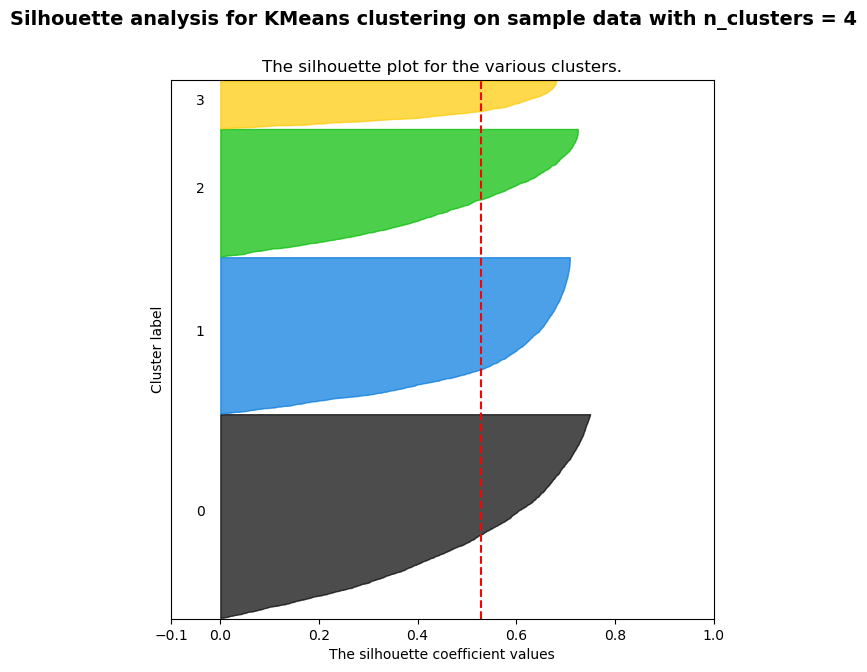

In [34]:
ncluster=4
import matplotlib.cm as cm
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(7, 7)
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(X) + (ncluster + 1) * 10])

# Initialize the clusterer with n_clusters value and a random generator
# seed of 10 for reproducibility.
clusterer = KMeans(n_clusters=ncluster, random_state=10)
cluster_labels = clusterer.fit_predict(X)

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed
# clusters
silhouette_avg = silhouette_score(X, cluster_labels)
print(f"For n_clusters = {ncluster}, the average silhouette_score is : {silhouette_avg:.3f}")

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, cluster_labels)

y_lower = 10
for i in range(ncluster):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ncluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % ncluster,
    fontsize=14,
    fontweight="bold",
)



In [35]:
mt_rainier['clusterID'] = clusterID
mt_rainier.to_csv('../data/Rainier_tsfel_features_clustered_kmeans.csv')

NameError: name 'clusterID' is not defined

### 3. Choice of number of clusters: The Elbow Method


Compute the value of E for different values of the number of clusters

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette_score is : 0.200


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette_score is : 0.172


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is : 0.160


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette_score is : 0.156


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette_score is : 0.156


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette_score is : 0.142


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette_score is : 0.131


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette_score is : 0.121


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette_score is : 0.113


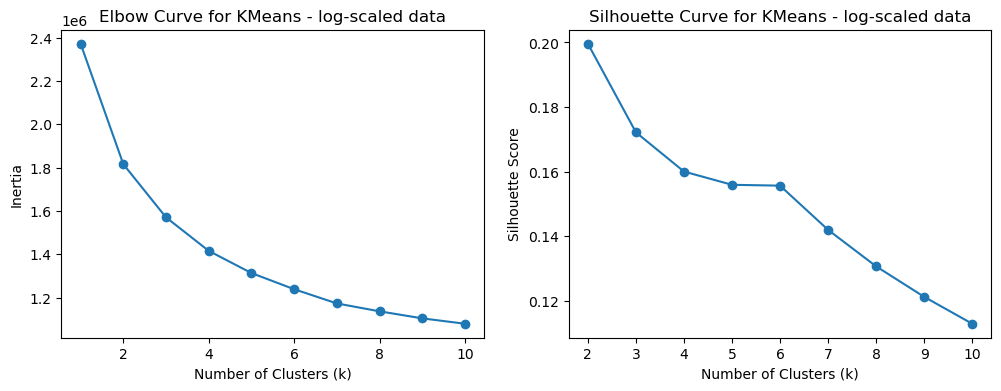

In [54]:
X = df_log_scaled.to_numpy()
# Elbow method  
inertia = []
silhouette_avg=[]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    if k>=2:
        silhouette_avg.append(silhouette_score(X, cluster_labels))
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg[-1]:.3f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(1, 11), inertia, marker='o')
ax[0].set_title('Elbow Curve for KMeans - log-scaled data')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[1].plot(range(2, 11), silhouette_avg, marker='o')
ax[1].set_title('Silhouette Curve for KMeans - log-scaled data')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette_score is : 0.581


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette_score is : 0.545


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is : 0.529


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette_score is : 0.534


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette_score is : 0.525


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette_score is : 0.530


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette_score is : 0.524


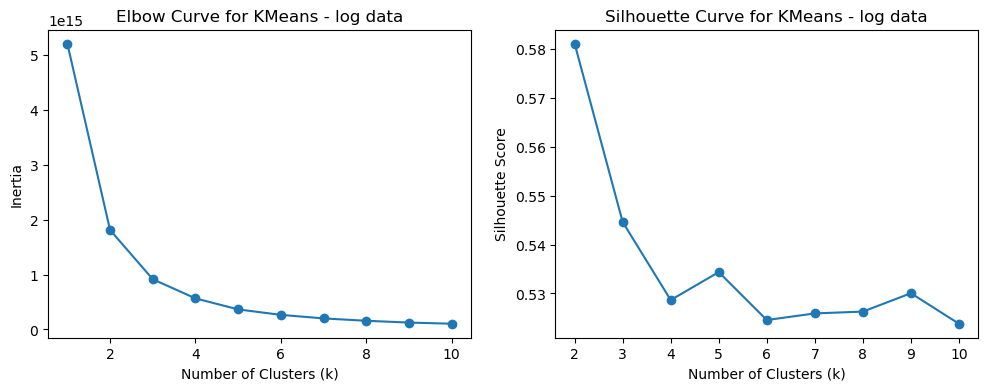

In [55]:
X = df_log.to_numpy()
# Elbow method  
inertia = []
silhouette_avg=[]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    if k>=2:
        silhouette_avg.append(silhouette_score(X, cluster_labels))
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg[-1]:.3f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(1, 11), inertia, marker='o')
ax[0].set_title('Elbow Curve for KMeans - log data')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[1].plot(range(2, 11), silhouette_avg, marker='o')
ax[1].set_title('Silhouette Curve for KMeans - log data')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 2, the average silhouette_score is : 0.581


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 3, the average silhouette_score is : 0.545


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 4, the average silhouette_score is : 0.529


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 5, the average silhouette_score is : 0.534


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 6, the average silhouette_score is : 0.525


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 7, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 8, the average silhouette_score is : 0.526


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 9, the average silhouette_score is : 0.530


/Users/marinedenolle/opt/miniconda3/envs/mlgeo/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


For n_clusters = 10, the average silhouette_score is : 0.524


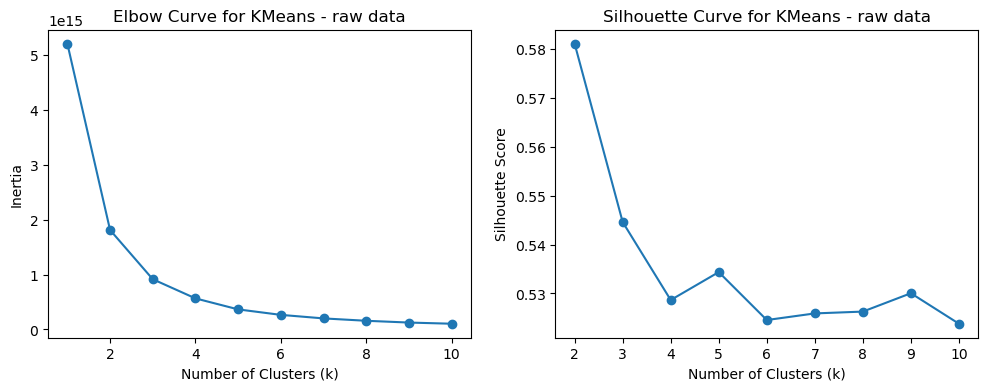

In [56]:
X = df.to_numpy()
# Elbow method  
inertia = []
silhouette_avg=[]
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    cluster_labels = kmeans.labels_
    inertia.append(kmeans.inertia_)
    if k>=2:
        silhouette_avg.append(silhouette_score(X, cluster_labels))
        print(f"For n_clusters = {k}, the average silhouette_score is : {silhouette_avg[-1]:.3f}")


fig, ax = plt.subplots(1, 2, figsize=(12, 4))
ax[0].plot(range(1, 11), inertia, marker='o')
ax[0].set_title('Elbow Curve for KMeans - raw data')
ax[0].set_xlabel('Number of Clusters (k)')
ax[0].set_ylabel('Inertia')
ax[1].plot(range(2, 11), silhouette_avg, marker='o')
ax[1].set_title('Silhouette Curve for KMeans - raw data')
ax[1].set_xlabel('Number of Clusters (k)')
ax[1].set_ylabel('Silhouette Score')
plt.show()

## 4. Hierarchical Clustering

In K-means, we use the euclidian distance and prescribe the number of clusters K.

In hierarchical clustering, we choose difference distance metrics, visualize the data structure, and then decide on the number of clusters. There are two approaches to building the hierarchy of clusters:

* **Agglomerative**: each point starts in each unique cluster. data is merged in pairs as on creates a hierarchy of clusters.
* **Divisive**: initially, all data is into 1 cluster. The data is recursively split into smaller and smaller clusters.


There are several types of *linkages*. sklearn has detailed [documentation](!https://scikit-learn.org/stable/modules/clustering.html#hierarchical-clustering), mostly for agglomerative: The different linkages methods are:

* **Ward** minimizes the sum of squared differences within all clusters. It is a variance-minimizing approach and in this sense is similar to the k-means objective function but tackled with an agglomerative hierarchical approach.
* **Maximum** or complete linkage minimizes the maximum distance between observations of pairs of clusters.
* **Average** linkage minimizes the average of the distances between all observations of pairs of clusters.
* **Single** linkage minimizes the distance between the closest observations of pairs of clusters.

We first import relevant packages



In [57]:

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.cluster import hierarchy  #
from scipy.spatial.distance import pdist

rcParams.update({'font.size': 18})
plt.rcParams['figure.figsize'] = [12, 12]

First we explore the dendograms

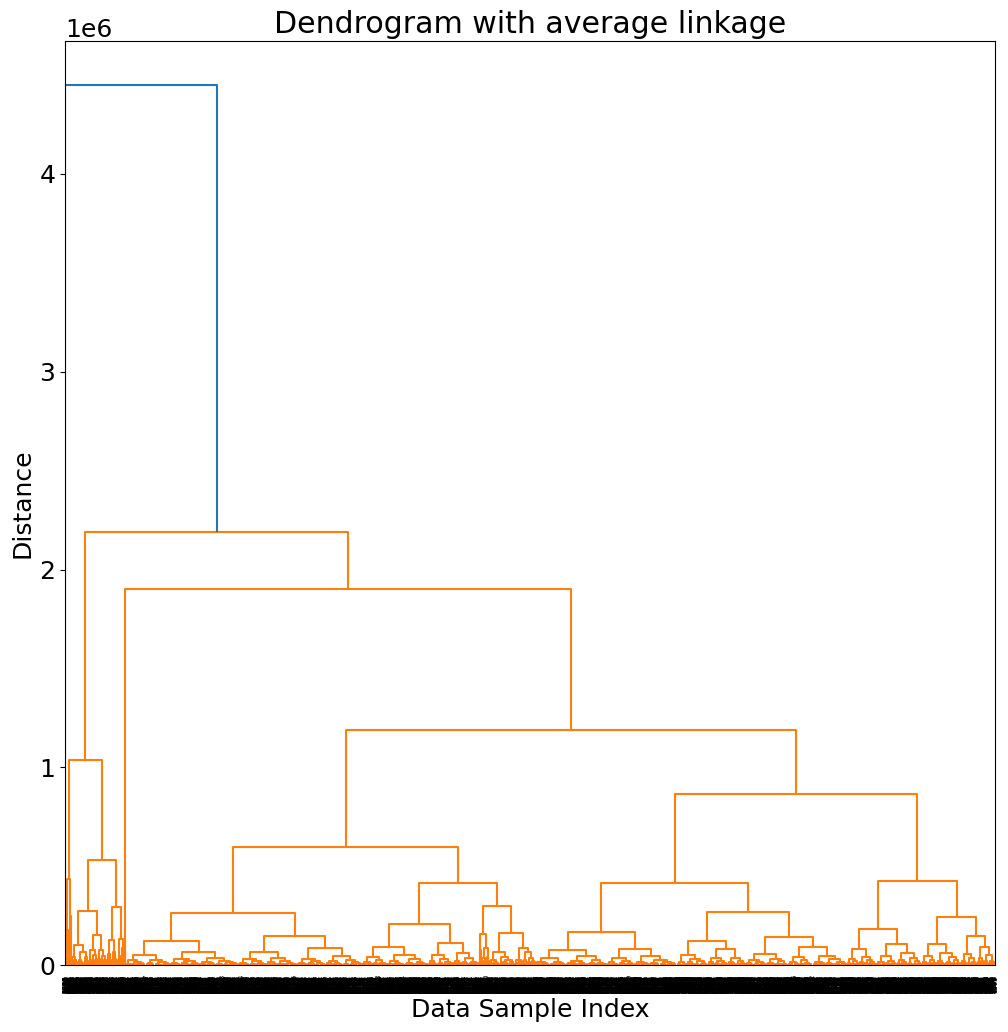

In [ ]:
## Dendrograms on raw data
X = df.to_numpy()
Y = pdist(X,metric='euclidean')
Z = hierarchy.linkage(Y,method='ward')
thresh = 0.85*np.max(Z[:,2])

plt.figure()
dn = hierarchy.dendrogram(Z,p=100,color_threshold=thresh)
plt.xlabel('Data Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram with Ward linkage')
plt.show()

In [59]:
## Dendrograms on log data
X = df_log.to_numpy()
Y = pdist(X,metric='euclidean')
Z = hierarchy.linkage(Y,method='average')
thresh = 0.85*np.max(Z[:,2])

plt.figure()
dn = hierarchy.dendrogram(Z,p=100,color_threshold=thresh)
plt.xlabel('Data Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram with average linkage')
plt.show()

##

Now let's cluster

In [ ]:
from sklearn.cluster import AgglomerativeClustering
# Let's first find a reasonable distance threshod by precalculating the linkage matrix
Z = hierarchy.linkage(X,method='average')
thresh = 0.4*np.max(Z[:,2])    # choose a threshold distance
print(thresh)
# design model
model = AgglomerativeClustering(distance_threshold=thresh,linkage="average", n_clusters=None)
# fit model and predict clusters on the data samples
clusterID=model.fit_predict(X)
print(clusterID)

In [ ]:
plt.hist(clusterID);

In [ ]:
ncluster=len(np.unique(clusterID))
silhouette_avg = silhouette_score(X, clusterID)
print(f"For n_clusters = {ncluster}, the average silhouette_score is : {silhouette_avg:.3f}")


In [ ]:

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (ncluster + 1) * 10])

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X, clusterID)

y_lower = 10
for i in range(ncluster):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[clusterID == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ncluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % ncluster,
    fontsize=14,
    fontweight="bold",
)



In [ ]:
mt_rainier['clusterID'] = clusterID

In [ ]:
mt_rainier.head()

In [ ]:
mt_rainier.to_csv('../data/Rainier_tsfel_features_clustered_agg.csv')

## Try PCA+normalization before clustering

What happens if we apply PCA + normalization before the clustering?

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

In [ ]:
scaler = preprocessing.StandardScaler().fit(X_pca)
X_scaled = scaler.transform(X_pca)

In [ ]:
# Let's first find a reasonable distance threshod by precalculating the linkage matrix
Z = hierarchy.linkage(X_scaled,method='average')
thresh = 0.3*np.max(Z[:,2])    # choose a threshold distance
print(thresh)

plt.figure()
dn = hierarchy.dendrogram(Z,p=100,color_threshold=thresh)
plt.xlabel('Data Sample Index')
plt.ylabel('Distance')
plt.title('Dendrogram with average linkage')
plt.show()
# design model
model = AgglomerativeClustering(distance_threshold=thresh,linkage="average", n_clusters=None)
# fit model and predict clusters on the data samples
clusterID=model.fit_predict(X_scaled)
plt.hist(clusterID);


In [ ]:
ncluster=len(np.unique(clusterID))
fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(18, 7)
ax1.set_xlim([-0.1, 1])
ax1.set_ylim([0, len(X) + (ncluster + 1) * 10])

silhouette_avg = silhouette_score(X_scaled, clusterID)
print(
    "For n_clusters =",
    ncluster,
    "The average silhouette_score is :",
    silhouette_avg,
)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(X_scaled, clusterID)

y_lower = 10
for i in range(ncluster):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[clusterID == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / ncluster)
    ax1.fill_betweenx(
        np.arange(y_lower, y_upper),
        0,
        ith_cluster_silhouette_values,
        facecolor=color,
        edgecolor=color,
        alpha=0.7,
    )

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

plt.suptitle(
    "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
    % ncluster,
    fontsize=14,
    fontweight="bold",
)

